In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os

In [3]:
resdir = 'taskRNN_results/PerceptualDecisionMaking_results/rnndim4_useinp1_histlen5_LN1_embdim0_projdim0_ptrain0.8_padstart0_maxepoch100_batchsize64_lr0.0025_lrschr0_lrstep1_lrgamma0.99_save1_seeds0,1,2,3,4'



In [4]:
with open(f'{resdir}/res.pkl', 'rb') as f:
    res = pickle.load(f)

In [5]:
for seed, v in res['test_r2_allseeds'].items():
    print(seed, v)

0 0.997459528046572
1 0.997629531436176
2 0.9983322892751659
3 0.9964305699784437
4 0.9974646314019342


In [ ]:
spear_cc = []
for seed, v in res['spear_cc_allseeds'].items():
    spear_cc.append(v)

In [9]:
spear_cc

[0.41958041958041964,
 0.6083916083916086,
 0.8251748251748254,
 0.8671328671328673,
 0.7482517482517484]

In [8]:
print(np.mean(spear_cc))
print(np.std(spear_cc))

0.6937062937062939
0.16294756711541514


In [10]:
spear_cc-np.mean(spear_cc)

array([-0.27412587, -0.08531469,  0.13146853,  0.17342657,  0.05454545])

In [11]:
pear_cc = []
for seed, v in res['pearson_cc_allseeds'].items():
    pear_cc.append(v)

In [14]:
pear_cc

[0.5421230869237047,
 0.7410202262659176,
 0.883665567058198,
 0.8508788267909553,
 0.7843118716631787]

In [13]:
print(np.mean(pear_cc))
print(np.std(pear_cc))

0.7603999157403909
0.11997748300256045


# Visualize NetFormer result 
load seed whose spearman cc is the closest to the average spearman cc across 5 seeds

In [15]:
GT = np.load('taskRNN_data/PerceptualDecisionMaking/rnn4/W_hidden_GT.npy')

In [16]:
offdiag_mask = ~np.eye(4, dtype=bool)

In [17]:
test_attn = np.load(f'{resdir}/test_attn_seed4.npy')
print(test_attn.shape)

(3400, 4, 7)


In [18]:
A = np.mean(test_attn, axis=0)[:, :4]
print(A.shape)

(4, 4)


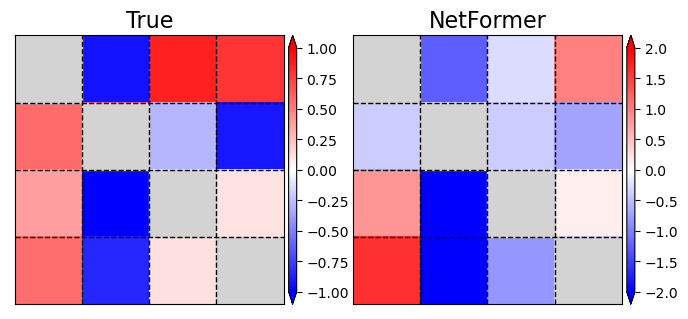

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')

vmax = 1
vmin = -1

c = ax.pcolor(GT, cmap='bwr', vmin=vmin, vmax=vmax)
for i in range(1, 4):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
# ax.xaxis.tick_top()

for i in range(4):
    ax.fill_between([i, i+1], i, i+1, color='lightgrey')
ax.set_title(r'True', fontsize=16)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical', extend='both')

ax = axes[1]
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')

vmax = 2
vmin = -2

c = ax.pcolor(A, cmap='bwr', vmin=vmin, vmax=vmax)
for i in range(1, 4):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
# ax.xaxis.tick_top()

for i in range(4):
    ax.fill_between([i, i+1], i, i+1, color='lightgrey')
ax.set_title(r'NetFormer', fontsize=16)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical', extend='both')

plt.show()

## Plot prediction

In [23]:
def make_data(rnn_activity, rnn_inputs=None, histlen=1, padstart=False, standardize=False):
    ntrial = rnn_activity.shape[0]
    triallen = rnn_activity.shape[1]
    nneur = rnn_activity.shape[2]

    if rnn_inputs is not None:
        rnn_inputs_ = np.zeros(rnn_inputs.shape)
        rnn_inputs_[:, :-1, :] = rnn_inputs[:, 1:, :]
        rnn_activity_inp = np.concatenate((rnn_activity, rnn_inputs_), axis=-1)
    else:
        rnn_activity_inp = rnn_activity
    if standardize:
        # Compute the mean and standard deviation along the first dimension
        mean = np.mean(rnn_activity_inp, axis=1, keepdims=True)  # Shape (1, 10, 4)
        print(mean.shape)
        std = np.std(rnn_activity_inp, axis=1, keepdims=True)  # Shape (1, 10, 4)
        print(std.shape)
        # Standardize the array
        rnn_activity_inp = (rnn_activity_inp - mean) / std

    nneurin = rnn_activity_inp.shape[2]

    if not padstart:  # start from the timestep with valid full history
        activity_aligned_alltrials = np.zeros((ntrial, triallen - histlen, nneurin, histlen))
        target_alltrials = np.zeros((ntrial, triallen - histlen, nneur, 1))
        for i in range(ntrial):
            activity_trial_i = rnn_activity_inp[i].T  # nneur x triallen
            for k in range(triallen - histlen):
                activity_aligned_alltrials[i][k] = activity_trial_i[:, k:k + histlen]
                target_alltrials[i][k, :, 0] = activity_trial_i[:nneur, k + histlen]

    else:  # start from the first timestep, pad invalid history with zero
        activity_aligned_alltrials = np.zeros((ntrial, triallen - 1, nneurin, histlen))
        target_alltrials = np.zeros((ntrial, triallen - 1, nneur, 1))
        for i in range(ntrial):
            padding = np.zeros((nneurin, histlen - 1))
            activity_trial_i = rnn_activity_inp[i].T  # nneur x triallen
            pad_activity_trial_i = np.hstack((padding, activity_trial_i))
            for k in range(triallen - 1):
                activity_aligned_alltrials[i][k] = pad_activity_trial_i[:, k + histlen - histlen:k + histlen]
                target_alltrials[i][k, :, 0] = activity_trial_i[:nneur, k + 1]

    return activity_aligned_alltrials, target_alltrials  # activity: (ntrial, samples per trial, nneurin, histlen), target: (ntrial, samples per trial, nneurin, 1)


In [32]:
train_activity_aligned_alltrials, train_target_alltrials = make_data(train_trials, rnn_inputs=train_stim, histlen=5,
                                                                       padstart=0)
print(train_activity_aligned_alltrials.shape, train_target_alltrials.shape)
inputs_train = train_activity_aligned_alltrials.reshape((train_activity_aligned_alltrials.shape[0] *
                                                       train_activity_aligned_alltrials.shape[1],
                                                       train_activity_aligned_alltrials.shape[2],
                                                       train_activity_aligned_alltrials.shape[3]))
targets_train = train_target_alltrials.reshape((train_target_alltrials.shape[0] * train_target_alltrials.shape[1],
                                              train_target_alltrials.shape[2], train_target_alltrials.shape[3]))

print(inputs_train.shape, targets_train.shape)


(800, 17, 7, 5) (800, 17, 4, 1)
(13600, 7, 5) (13600, 4, 1)


In [33]:
test_activity_aligned_alltrials, test_target_alltrials = make_data(test_trials, rnn_inputs=test_stim, histlen=5,
                                                                       padstart=0)
print(test_activity_aligned_alltrials.shape, test_target_alltrials.shape)
inputs_test = test_activity_aligned_alltrials.reshape((test_activity_aligned_alltrials.shape[0] *
                                                       test_activity_aligned_alltrials.shape[1],
                                                       test_activity_aligned_alltrials.shape[2],
                                                       test_activity_aligned_alltrials.shape[3]))
targets_test = test_target_alltrials.reshape((test_target_alltrials.shape[0] * test_target_alltrials.shape[1],
                                              test_target_alltrials.shape[2], test_target_alltrials.shape[3]))

print(inputs_test.shape, targets_test.shape)

(200, 17, 7, 5) (200, 17, 4, 1)
(3400, 7, 5) (3400, 4, 1)


In [34]:
test_pred_i = np.load(f'{resdir}/test_pred_seed4.npy')

In [35]:
test_pred_i.shape

(3400, 4, 1)

In [36]:
test_pred_i = test_pred_i.reshape((200, 17, 4, 1))

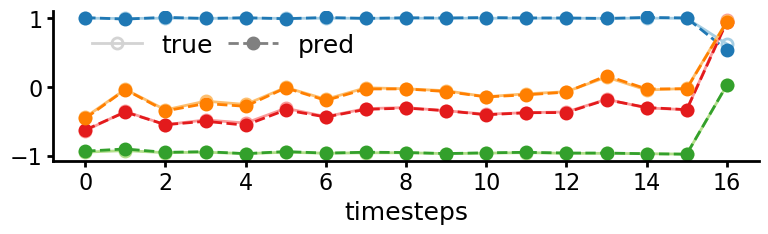

In [29]:
fig, ax = plt.subplots(figsize=(8, 3))
cmap = plt.get_cmap('Paired')
for i in range(4):
    ax.plot(test_target_alltrials[0, :, i, 0], '-o', linewidth=2, ms=8, markerfacecolor='none', markeredgewidth=2, color=cmap(i*2))
    ax.plot(test_pred_i[0, :, i, 0], '--o', linewidth=2, ms=8, markeredgewidth=2, color=cmap(i*2+1))

ax.plot([], [], '-o', linewidth=2, ms=8, markeredgewidth=2, markerfacecolor='none', color='lightgrey', label='true')
ax.plot([], [], '--o', linewidth=2, ms=8, markeredgewidth=2, color='grey', label='pred')
ax.legend(bbox_to_anchor=(0.46, 1), ncol=3, columnspacing=0.6, frameon=False, fontsize=18)

ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines[['top', 'right']].set_visible(False)
ax.xaxis.set_tick_params(width=2, length=4)
ax.yaxis.set_tick_params(width=2, length=4)


plt.xlabel('timesteps', fontsize=18)
plt.tight_layout()
plt.show()

## Fit linear regression model

In [30]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [37]:
# fit linear regression model
print(inputs_train.shape, targets_train.shape)
print(inputs_test.shape, targets_test.shape)

(13600, 7, 5) (13600, 4, 1)
(3400, 7, 5) (3400, 4, 1)


In [40]:
x_train_inp_flat = inputs_train[:, :, -1]
x_test_inp_flat = inputs_test[:, :, -1]
x_train_tag = np.squeeze(targets_train)
x_test_tag = np.squeeze(targets_test)

print(x_train_inp_flat.shape, x_test_inp_flat.shape, x_train_tag.shape, x_test_tag.shape)

(13600, 7) (3400, 7) (13600, 4) (3400, 4)


In [41]:
A_ols = np.linalg.inv(x_train_inp_flat.T @ x_train_inp_flat) @ x_train_inp_flat.T @ x_train_tag

In [42]:
A_ols.shape

(7, 4)

In [43]:
A_ols_neur = A_ols[:4, :].T

In [44]:
stats.spearmanr(GT[offdiag_mask].flatten(), A_ols_neur[offdiag_mask].flatten())

SpearmanrResult(correlation=0.5664335664335665, pvalue=0.054842119775407844)

In [45]:
stats.pearsonr(GT[offdiag_mask].flatten(), A_ols_neur[offdiag_mask].flatten())

PearsonRResult(statistic=0.54824850873306, pvalue=0.06495198810559402)

In [46]:
test_pred_ols = x_test_inp_flat @ A_ols

In [47]:
test_pred_ols.shape

(3400, 4)

In [48]:
mean_squared_error(x_test_tag, test_pred_ols)

0.014121761072321286

In [49]:
r2_score(x_test_tag, test_pred_ols)

0.9194886785717007

In [50]:
mse_allseeds = []
r2_allseeds = []

for s in range(5):
    test_pred_s = np.load(f'{resdir}/test_pred_seed{s}.npy')
    test_pred_s = np.squeeze(test_pred_s)
    mse_allseeds.append(mean_squared_error(x_test_tag, test_pred_s))
    r2_allseeds.append(r2_score(x_test_tag, test_pred_s))

In [51]:
mse_allseeds

[0.0004204070565817104,
 0.00038712839742246856,
 0.0002899186442523281,
 0.0006282852049832386,
 0.00040185628112611536]

In [52]:
np.mean(mse_allseeds), np.std(mse_allseeds)

(0.0004255191168731721, 0.00011096079033461676)

In [53]:
r2_allseeds

[0.9974595280435012,
 0.9976295314351595,
 0.9983322892720287,
 0.9964305699771413,
 0.9974646314134925]

In [54]:
np.mean(r2_allseeds), np.std(r2_allseeds)

(0.9974633100282645, 0.0006081648698938006)

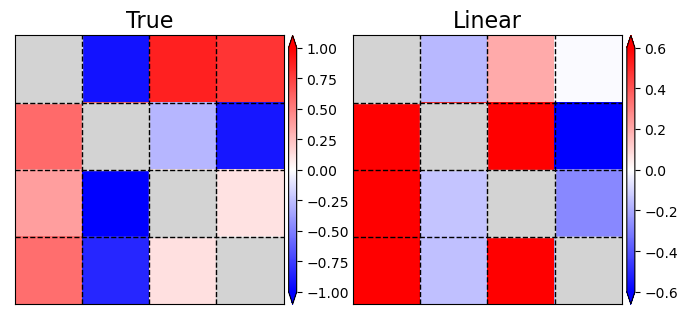

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')

vmax = 1
vmin = -1

c = ax.pcolor(GT, cmap='bwr', vmin=vmin, vmax=vmax)
for i in range(1, 4):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
# ax.xaxis.tick_top()

for i in range(4):
    ax.fill_between([i, i+1], i, i+1, color='lightgrey')
ax.set_title(r'True', fontsize=16)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical', extend='both')

ax = axes[1]
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')

vmax = 0.6
vmin = -0.6

c = ax.pcolor(A_ols_neur, cmap='bwr', vmin=vmin, vmax=vmax)
for i in range(1, 4):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
# ax.xaxis.tick_top()

for i in range(4):
    ax.fill_between([i, i+1], i, i+1, color='lightgrey')
ax.set_title(r'Linear', fontsize=16)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical', extend='both')

plt.show()

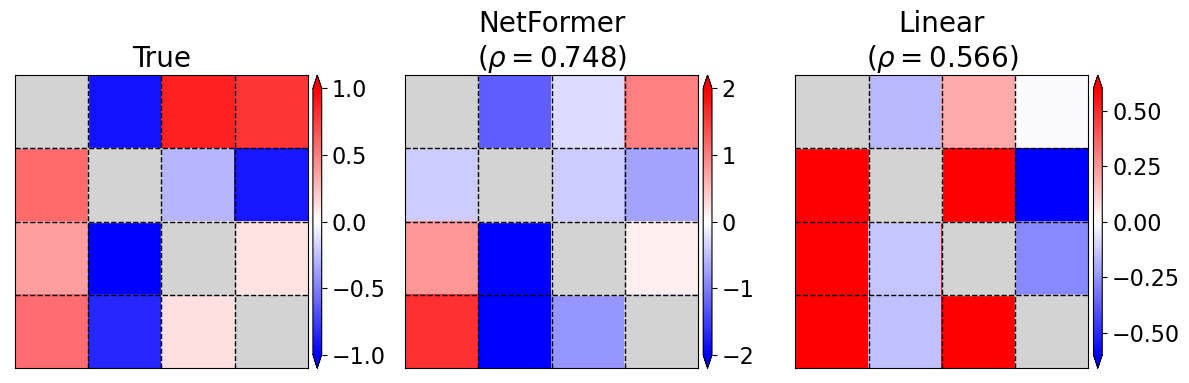

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#################### True #####################
ax = axes[0]
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')

vmax = 1
vmin = -1

c = ax.pcolor(GT, cmap='bwr', vmin=vmin, vmax=vmax)
for i in range(1, 4):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
# ax.xaxis.tick_top()

for i in range(4):
    ax.fill_between([i, i+1], i, i+1, color='lightgrey')
ax.set_title(r'True', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
cbar = fig.colorbar(c, cax=cax, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=16)

#################### netformer #####################
ax = axes[1]
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')

vmax = 2
vmin = -2

c = ax.pcolor(A, cmap='bwr', vmin=vmin, vmax=vmax)
for i in range(1, 4):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
# ax.xaxis.tick_top()

for i in range(4):
    ax.fill_between([i, i+1], i, i+1, color='lightgrey')
# ax.set_title(r'NetFormer', fontsize=20)
ax.set_title('NetFormer\n'+r'($\rho=$'+f'{stats.spearmanr(GT[offdiag_mask].flatten(), A[offdiag_mask].flatten()).correlation:.3f})', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
cbar = fig.colorbar(c, cax=cax, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=16)

#################### linear #####################
ax = axes[2]
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')

vmax = 0.6
vmin = -0.6

c = ax.pcolor(A_ols_neur, cmap='bwr', vmin=vmin, vmax=vmax)
for i in range(1, 4):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
# ax.xaxis.tick_top()

for i in range(4):
    ax.fill_between([i, i+1], i, i+1, color='lightgrey')
# ax.set_title(r'Linear', fontsize=20)
ax.set_title('Linear\n'+r'($\rho=$'+f'{stats.spearmanr(GT[offdiag_mask].flatten(), A_ols_neur[offdiag_mask].flatten()).correlation:.3f})', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
cbar = fig.colorbar(c, cax=cax, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

In [63]:
A_reg = LinearRegression().fit(GT[offdiag_mask].ravel().reshape((-1, 1)), A[offdiag_mask].ravel())

In [64]:
A_ols_reg = LinearRegression().fit(GT[offdiag_mask].ravel().reshape((-1, 1)), A_ols_neur[offdiag_mask].ravel())

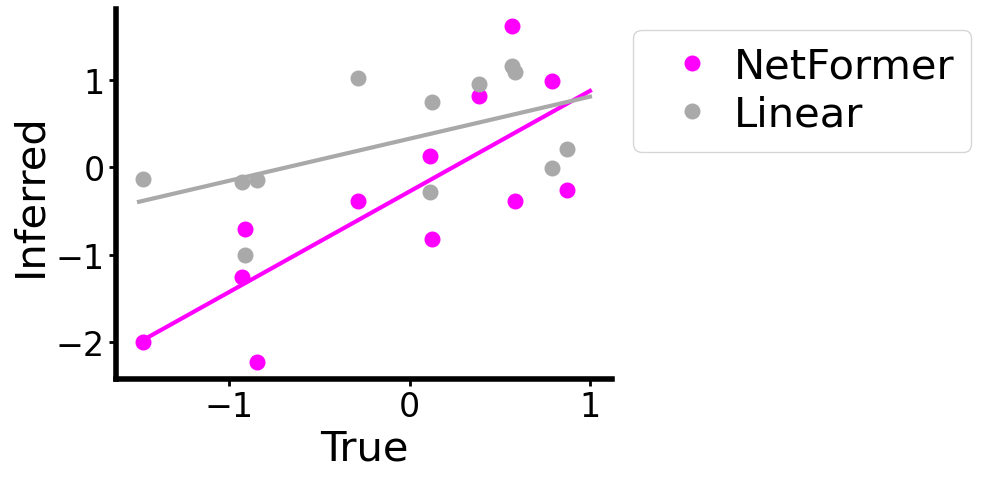

In [65]:
fig, ax = plt.subplots()
ax.plot(GT[offdiag_mask].ravel(), A[offdiag_mask].ravel(), 'o', c='magenta', ms=10, markeredgewidth=1.5, label='NetFormer')
ax.plot(GT[offdiag_mask].ravel(), A_ols_neur[offdiag_mask].ravel(), 'o', c='darkgray', ms=10, markeredgewidth=1.5, label='Linear')

ax.plot(np.array([-1.5, 1]), A_reg.coef_*np.array([-1.5, 1])+A_reg.intercept_, c='magenta', lw=3)
ax.plot(np.array([-1.5, 1]), A_ols_reg.coef_*np.array([-1.5, 1])+A_ols_reg.intercept_, c='darkgray', lw=3)

ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=24)
ax.tick_params(axis='y', which='major', labelsize=24)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
    
# ax.grid()
ax.xaxis.set_tick_params(width=2, length=5)
ax.yaxis.set_tick_params(width=2, length=5)
ax.set_xlabel('True', fontsize=30)
ax.set_ylabel('Inferred', fontsize=30)
ax.legend(fontsize=30, labelspacing=0.2, handletextpad=0.01, bbox_to_anchor=(1, 1))
plt.show()